In [ ]:
#COMPONENT 5: TRAFFIC FORECASTING MODEL DEVELOPMENT & EVALUATION

#Project: Predict hourly traffic volumes at road junctions
#File Required: traffic_data_with_features.csv

# step-1: IMPORT ALL NECESSARY LIBRARIES
#LOADING LIBRARIES
#Importing required packages

# Basic data handling
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Model Building
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("All libraries loaded successfully!\n")

All libraries loaded successfully!



In [ ]:
# step-2: LOAD THE DATA
#LOADING DATA
# Load the preprocessed data with features
data = pd.read_csv('traffic_data_with_features.csv')

print(f"\n Dataset Information:")
print(f"   • Total Rows: {data.shape[0]:,}")
print(f"   • Total Columns: {data.shape[1]}")
print(f"\n Data loaded successfully!")

# Display first few rows
print("\n First 5 rows of data:")
print(data.head())

# Show all column names
print("\n Available Columns:")
for i, col in enumerate(data.columns, 1):
    print(f"   {i:2d}. {col}")


 Dataset Information:
   • Total Rows: 48,120
   • Total Columns: 25

 Data loaded successfully!

 First 5 rows of data:
   Junction        Date  Hour  Vehicles  DayOfWeek  Month  Year  Hour_sin  \
0         1  2015-11-01     0        15          6     11  2015  0.000000   
1         1  2015-11-01     1        13          6     11  2015  0.258819   
2         1  2015-11-01     2        10          6     11  2015  0.500000   
3         1  2015-11-01     3         7          6     11  2015  0.707107   
4         1  2015-11-01     4         9          6     11  2015  0.866025   

   Hour_cos  DayOfWeek_sin  ...  Vehicles_lag_12h  Vehicles_lag_24h  \
0  1.000000      -0.781831  ...               NaN               NaN   
1  0.965926      -0.781831  ...               NaN               NaN   
2  0.866025      -0.781831  ...               NaN               NaN   
3  0.707107      -0.781831  ...               NaN               NaN   
4  0.500000      -0.781831  ...               NaN           

In [ ]:
# step-3: PREPARE DATA FOR MODELING
# Convert Date column to datetime
print("\n Processing Date column...")
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Junction', 'Date', 'Hour']).reset_index(drop=True)

# Define target variable (what we want to predict)
target_col = 'Vehicles'
print(f"\nTarget Variable: {target_col}")

# Define features (what we use to make predictions)
# Using features that exist in your data
feature_cols = [
    'Hour',              # Hour of day (0-23)
    'DayOfWeek',         # Day of week (0-6)
    'Month',             # Month (1-12)
    'Hour_sin',          # Cyclical encoding of hour
    'Hour_cos',          # Cyclical encoding of hour
    'DayOfWeek_sin',     # Cyclical encoding of day
    'DayOfWeek_cos',     # Cyclical encoding of day
    'IsWeekend',         # Is it weekend? (0/1)
    'IsMorningRush',     # Morning rush hour (0/1)
    'IsEveningRush',     # Evening rush hour (0/1)
    'IsRushHour',        # Any rush hour (0/1)
    'IsSpecialEvent'     # Special event day (0/1)
]

print(f"\n Using {len(feature_cols)} features:")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {col}")

# Create X (features) and y (target)
X = data[feature_cols].copy()
y = data[target_col].copy()

# Handle missing values if any
print(f"\nChecking for missing values...")
missing = X.isnull().sum().sum()
if missing > 0:
    print(f"    Found {missing} missing values - filling with median")
    X = X.fillna(X.median())
else:
    print(" No missing values found!")

print(f"\n Data preparation complete!")
print(f"   • Total samples: {len(X):,}")
print(f"   • Features: {len(feature_cols)}")
print(f"   • Target range: {y.min()} to {y.max()}")


 Processing Date column...

Target Variable: Vehicles

 Using 12 features:
    1. Hour
    2. DayOfWeek
    3. Month
    4. Hour_sin
    5. Hour_cos
    6. DayOfWeek_sin
    7. DayOfWeek_cos
    8. IsWeekend
    9. IsMorningRush
   10. IsEveningRush
   11. IsRushHour
   12. IsSpecialEvent

Checking for missing values...
 No missing values found!

 Data preparation complete!
   • Total samples: 48,120
   • Features: 12
   • Target range: 1 to 180


In [ ]:
# step-4: SPLIT DATA INTO TRAIN AND TEST SETS
# SPLITTING DATA


# For time series, we split chronologically
# First 80% for training, last 20% for testing
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx].copy()
X_test = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_test = y.iloc[split_idx:].copy()

print(f"\n Split Summary:")
print(f"   • Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   • Testing set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n Training Target Statistics:")
print(f"   • Min: {y_train.min()}")
print(f"   • Max: {y_train.max()}")
print(f"   • Mean: {y_train.mean():.2f}")

print("\n Data split complete!")


 Split Summary:
   • Training set: 38,496 samples (80.0%)
   • Testing set: 9,624 samples (20.0%)

 Training Target Statistics:
   • Min: 1
   • Max: 156
   • Mean: 25.34

 Data split complete!


In [ ]:
# step-5: SCALE THE FEATURES
# SCALING FEATURES

print("\n Applying StandardScaler...")
print("   (This makes all features have mean=0 and std=1)")

# Create and fit scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n Scaling complete!")
print("   • Method: StandardScaler")
print("   • All features now on same scale")


 Applying StandardScaler...
   (This makes all features have mean=0 and std=1)

 Scaling complete!
   • Method: StandardScaler
   • All features now on same scale


In [ ]:
# step-6: BUILD MODEL 1 - LINEAR REGRESSION


print("\n Training Linear Regression...")
print("   (Simple model that finds straight-line relationships)")

# Create and train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_pred_train = lr_model.predict(X_train_scaled)
lr_pred_test = lr_model.predict(X_test_scaled)

print(" Linear Regression trained!")


 Training Linear Regression...
   (Simple model that finds straight-line relationships)
 Linear Regression trained!


In [ ]:
# step-7: BUILD MODEL 2 - RANDOM FOREST
print("\n Training Random Forest...")
print("   (Creates 100 decision trees and averages their predictions)")

# Create and train model
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=15,          # Maximum tree depth
    min_samples_split=10,  # Minimum samples to split
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all CPU cores
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred_train = rf_model.predict(X_train_scaled)
rf_pred_test = rf_model.predict(X_test_scaled)

print(" Random Forest trained!")


 Training Random Forest...
   (Creates 100 decision trees and averages their predictions)
 Random Forest trained!


In [ ]:
# step-8: BUILD MODEL 3 - GRADIENT BOOSTING

print("\n Training Gradient Boosting...")
print("   (Builds trees sequentially, each fixing previous errors)")

# Create and train model
gb_model = GradientBoostingRegressor(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # How fast it learns
    max_depth=5,           # Maximum tree depth
    random_state=42        # For reproducibility
)
gb_model.fit(X_train_scaled, y_train)

# Make predictions
gb_pred_train = gb_model.predict(X_train_scaled)
gb_pred_test = gb_model.predict(X_test_scaled)

print(" Gradient Boosting trained!")
print(" ALL 3 MODELS TRAINED SUCCESSFULLY!")


 Training Gradient Boosting...
   (Builds trees sequentially, each fixing previous errors)
 Gradient Boosting trained!
 ALL 3 MODELS TRAINED SUCCESSFULLY!


In [ ]:
# step-9: EVALUATE ALL MODELS

#EVALUATING MODEL PERFORMANCE


# Function to calculate metrics
def calculate_metrics(y_true, y_pred, model_name):
    """Calculate all evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R² Score': r2,
        'MAPE (%)': mape
    }

# Evaluate all models on test data
print("\n Calculating performance metrics.")

results = []
results.append(calculate_metrics(y_test, lr_pred_test, 'Linear Regression'))
results.append(calculate_metrics(y_test, rf_pred_test, 'Random Forest'))
results.append(calculate_metrics(y_test, gb_pred_test, 'Gradient Boosting'))

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R² Score', ascending=False)


print("MODEL PERFORMANCE COMPARISON (Test Set)")

print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n BEST MODEL: {best_model_name}")


# Explain metrics
print("\n Understanding the Metrics:")

print("MAE (Mean Absolute Error):")
print("   → Average error in number of vehicles")
print("   → Lower is better")
print()
print("RMSE (Root Mean Squared Error):")
print("   → Similar to MAE but penalizes large errors more")
print("   → Lower is better")
print()
print("R² Score (R-Squared):")
print("   → Percentage of variance explained (0 to 1)")
print("   → Higher is better (1.0 = perfect)")
print()
print("MAPE (Mean Absolute Percentage Error):")
print("   → Average error as a percentage")
print("   → Lower is better")


 Calculating performance metrics.
MODEL PERFORMANCE COMPARISON (Test Set)
            Model       MAE      RMSE  R² Score   MAPE (%)
Linear Regression 15.124623 17.103305 -1.944518 206.606182
Gradient Boosting 15.708399 18.137911 -2.311529 207.602585
    Random Forest 15.739016 18.194396 -2.332187 207.771480

 BEST MODEL: Linear Regression

 Understanding the Metrics:
MAE (Mean Absolute Error):
   → Average error in number of vehicles
   → Lower is better

RMSE (Root Mean Squared Error):
   → Similar to MAE but penalizes large errors more
   → Lower is better

R² Score (R-Squared):
   → Percentage of variance explained (0 to 1)
   → Higher is better (1.0 = perfect)

MAPE (Mean Absolute Percentage Error):
   → Average error as a percentage
   → Lower is better



 Saved: model_predictions_comparison.png


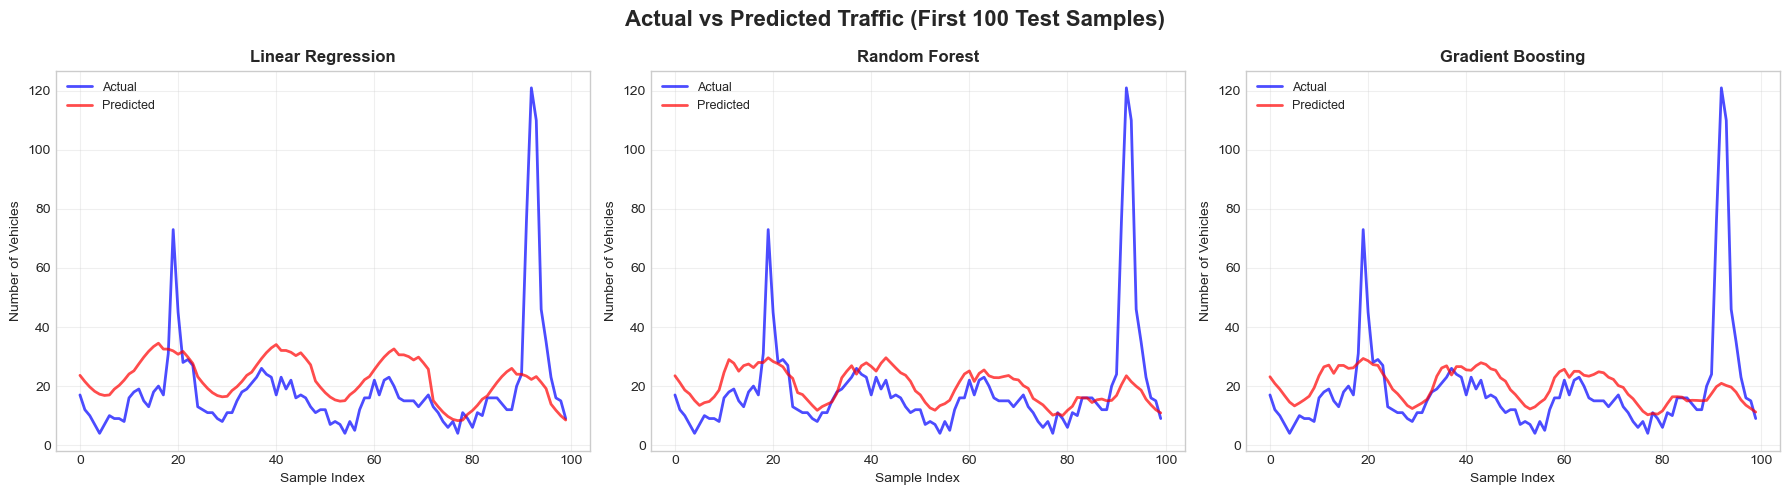

In [ ]:
# step- 10: VISUALIZE PREDICTIONS
# CREATING VISUALIZATIONS


# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Actual vs Predicted Traffic (First 100 Test Samples)',
             fontsize=16, fontweight='bold')

models = {
    'Linear Regression': lr_pred_test,
    'Random Forest': rf_pred_test,
    'Gradient Boosting': gb_pred_test
}

for idx, (name, pred) in enumerate(models.items()):
    ax = axes[idx]

    # Plot actual vs predicted
    sample_size = 100
    ax.plot(y_test.values[:sample_size], label='Actual',
            linewidth=2, alpha=0.7, color='blue')
    ax.plot(pred[:sample_size], label='Predicted',
            linewidth=2, alpha=0.7, color='red')

    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index', fontsize=10)
    ax.set_ylabel('Number of Vehicles', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_predictions_comparison.png', dpi=300, bbox_inches='tight')
print("\n Saved: model_predictions_comparison.png")
plt.show()


 FEATURE IMPORTANCE RANKING:
Hour                 : 0.3894
Month                : 0.2324
DayOfWeek            : 0.1038
DayOfWeek_sin        : 0.0767
Hour_cos             : 0.0561
Hour_sin             : 0.0537
IsWeekend            : 0.0524
DayOfWeek_cos        : 0.0238
IsRushHour           : 0.0049
IsMorningRush        : 0.0038
IsEveningRush        : 0.0030
IsSpecialEvent       : 0.0000

 Saved: feature_importance.png


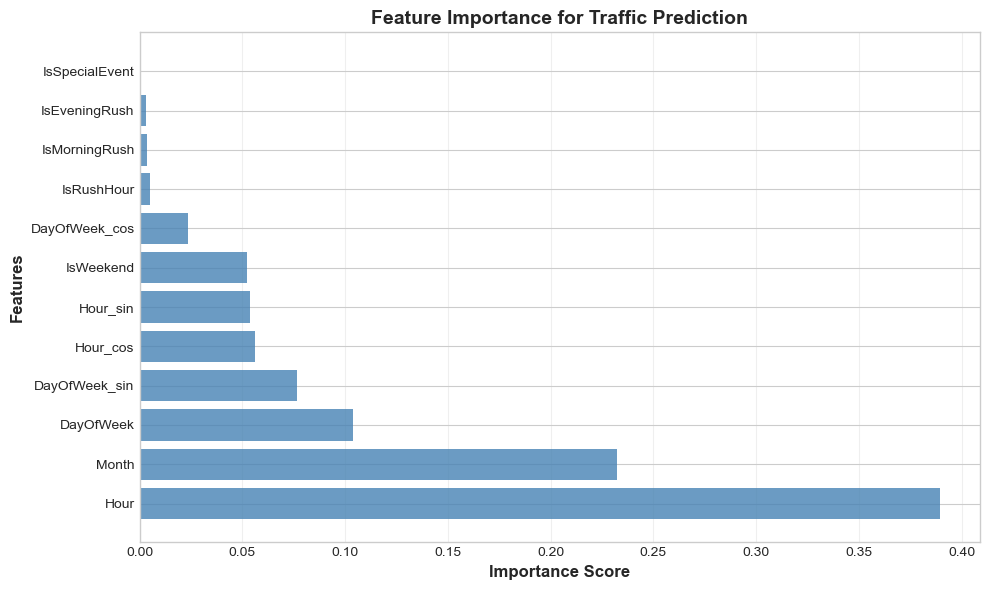

In [ ]:
# step- 11: FEATURE IMPORTANCE
# ANALYZING FEATURE IMPORTANCE

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n FEATURE IMPORTANCE RANKING:")

for idx, row in feature_importance.iterrows():
    print(f"{row['Feature']:20s} : {row['Importance']:.4f}")

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'],
         color='steelblue', alpha=0.8)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Feature Importance for Traffic Prediction',
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\n Saved: feature_importance.png")
plt.show()

In [ ]:
# step-12: CROSS-VALIDATION


print("\n Performing 5-fold time series cross-validation...")
print("   (Testing model on different time periods)")

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

cv_results = {}
for name, model in [('Linear Regression', lr_model),
                     ('Random Forest', rf_model),
                     ('Gradient Boosting', gb_model)]:

    print(f"\n   Testing {name}...")
    scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rmse_scores = np.sqrt(-scores)

    cv_results[name] = {
        'Mean RMSE': rmse_scores.mean(),
        'Std RMSE': rmse_scores.std()
    }

    print(f"      Mean RMSE: {rmse_scores.mean():.2f}")
    print(f"      Std RMSE: {rmse_scores.std():.2f}")

print("\n Cross-validation complete!")


 Performing 5-fold time series cross-validation...
   (Testing model on different time periods)

   Testing Linear Regression...
      Mean RMSE: 24.46
      Std RMSE: 6.15

   Testing Random Forest...
      Mean RMSE: 26.88
      Std RMSE: 6.41

   Testing Gradient Boosting...
      Mean RMSE: 26.81
      Std RMSE: 6.40

 Cross-validation complete!



 Error Statistics for Linear Regression:
   • Mean Error: -13.89
   • Std Error: 9.98
   • Min Error: -35.15
   • Max Error: 143.34

 Saved: error_analysis.png


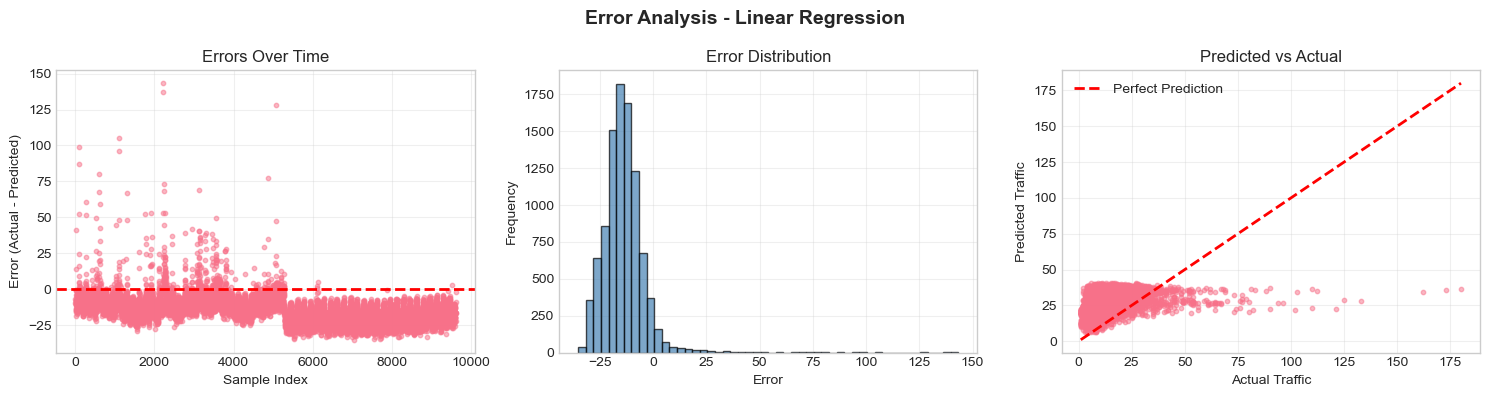

In [ ]:
# step-13: ERROR ANALYSIS

# Select best model predictions
if best_model_name == 'Linear Regression':
    best_pred = lr_pred_test
elif best_model_name == 'Random Forest':
    best_pred = rf_pred_test
else:
    best_pred = gb_pred_test

# Calculate residuals (errors)
residuals = y_test - best_pred

print(f"\n Error Statistics for {best_model_name}:")
print(f"   • Mean Error: {residuals.mean():.2f}")
print(f"   • Std Error: {residuals.std():.2f}")
print(f"   • Min Error: {residuals.min():.2f}")
print(f"   • Max Error: {residuals.max():.2f}")

# Create error analysis plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f'Error Analysis - {best_model_name}',
             fontsize=14, fontweight='bold')

# Plot 1: Residuals over time
axes[0].scatter(range(len(residuals)), residuals, alpha=0.5, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_title('Errors Over Time')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Error (Actual - Predicted)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Error distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_title('Error Distribution')
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Plot 3: Predicted vs Actual
axes[2].scatter(y_test, best_pred, alpha=0.5, s=10)
axes[2].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[2].set_title('Predicted vs Actual')
axes[2].set_xlabel('Actual Traffic')
axes[2].set_ylabel('Predicted Traffic')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
print("\n Saved: error_analysis.png")
plt.show()

In [ ]:

# step-14: FINAL SUMMARY AND SAVE RESULTS
# Get best model metrics
best_metrics = results_df.iloc[0]

print(f"\n BEST MODEL: {best_model_name}")

print(f"MAE:  {best_metrics['MAE']:.2f} vehicles")
print(f"RMSE: {best_metrics['RMSE']:.2f} vehicles")
print(f"R²:   {best_metrics['R² Score']:.4f} ({best_metrics['R² Score']*100:.2f}%)")
print(f"MAPE: {best_metrics['MAPE (%)']:.2f}%")

print("\n What This Means:")

print(f"• On average, predictions are off by ±{best_metrics['MAE']:.0f} vehicles")
print(f"• Model explains {best_metrics['R² Score']*100:.1f}% of traffic variation")
print(f"• Typical error is about {best_metrics['MAPE (%)']:.1f}% of actual traffic")

print("\n Top 3 Most Important Features:")

for i in range(min(3, len(feature_importance))):
    feat = feature_importance.iloc[i]
    print(f"{i+1}. {feat['Feature']:20s} (Importance: {feat['Importance']:.4f})")

# Save all results
print("\n Saving Results...")


# Save performance metrics
results_df.to_csv('model_evaluation_results.csv', index=False)
print(" Saved: model_evaluation_results.csv")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print(" Saved: feature_importance.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'LinearRegression_Pred': lr_pred_test,
    'RandomForest_Pred': rf_pred_test,
    'GradientBoosting_Pred': gb_pred_test
})
predictions_df.to_csv('model_predictions.csv', index=False)
print(" Saved: model_predictions.csv")





 BEST MODEL: Linear Regression
MAE:  15.12 vehicles
RMSE: 17.10 vehicles
R²:   -1.9445 (-194.45%)
MAPE: 206.61%

 What This Means:
• On average, predictions are off by ±15 vehicles
• Model explains -194.5% of traffic variation
• Typical error is about 206.6% of actual traffic

 Top 3 Most Important Features:
1. Hour                 (Importance: 0.3894)
2. Month                (Importance: 0.2324)
3. DayOfWeek            (Importance: 0.1038)

 Saving Results...
 Saved: model_evaluation_results.csv
 Saved: feature_importance.csv
 Saved: model_predictions.csv


checklist: COMPONENT 5 COMPLETE!

All models trained and evaluated successfully!
All visualizations created!
All results saved!
Output Files Created:
1. model_predictions_comparison.png
2. feature_importance.png
3.error_analysis.png
4. model_evaluation_results.csv
5. feature_importance.csv
6. model_predictions.csv    